In [1]:
from scipy.optimize import minimize
import numpy as np
from pmsm_tools import phi_eval_2,i_eval_2,phi_eval_3
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numba

In [2]:
%matplotlib widget

In [3]:
data_i2p = loadmat('pmsm_data.mat')

In [4]:
Phi_d_i2p,Phi_q_i2p = data_i2p['fluxD'],data_i2p['fluxQ']
I_d_i2p,I_q_i2p = data_i2p['idVec'].astype(np.float64)[0,:],data_i2p['iqVec'].astype(np.float64)[0,:]
Theta_i2p = data_i2p['angleVec'].astype(np.float64)[0,:]
Torque_i2p = data_i2p['torque'].astype(np.float64)

np.savez(f'pmsm_i2phi', phi_d=Phi_d_i2p, phi_q=Phi_q_i2p, theta=Theta_i2p,
                            i_d=I_d_i2p, i_q=I_q_i2p, torque=Torque_i2p)

Phi_m = Phi_d_i2p[10,10,0]
L_d = (Phi_d_i2p[11,10,0]-Phi_d_i2p[9,10,0])/(I_d_i2p[11]-I_d_i2p[9])
L_q = (Phi_q_i2p[10,11,0]-Phi_q_i2p[10,9,0])/(I_q_i2p[11]-I_q_i2p[9])

R_s = 0.07
N_pp = 4

R_l = 10.0

In [5]:
class optimizer:
    
    def __init__(self,Phi_d_i2p,Phi_q_i2p,I_d_i2p,I_q_i2p,Theta_i2p):
        self.phi_d = 0.5
        self.phi_q = 0.2
        self.theta = 0.0
        
        self.Phi_d = Phi_d_i2p
        self.Phi_q = Phi_q_i2p
        self.Torque = Torque_i2p
        self.I_d = I_d_i2p
        self.I_q = I_q_i2p
        self.Theta = Theta_i2p
        
    def obj_eval(self,x):

        i_d = x[0]
        i_q = x[1]
        theta = self.theta

        #if i_d<300.0: i_d=-300.0
        #if i_d>300.0: i_d=300.0
        #if i_q<300.0: i_q=-300.0
        #if i_q>300.0: i_q=300.0
        #if theta<0.0: theta=0.0
        #if theta>2*np.pi: theta=2*np.pi
            
        #phi_d,phi_q,L_s = phi_eval_2(i_d,i_q,theta,self.Phi_d,self.Phi_q,self.I_d,self.I_q,self.Theta)
        phi_d,phi_q,torque,L_s = phi_eval_3(i_d,i_q,theta,self.Phi_d,self.Phi_q,self.Torque,self.I_d,self.I_q,self.Theta)
        
        obj = (phi_d - self.phi_d)**2 + (phi_q - self.phi_q)**2
        
        return obj

In [6]:
opt = optimizer(Phi_d_i2p,Phi_q_i2p,I_d_i2p,I_q_i2p,Theta_i2p)  
opt.theta = 0
Theta_p2i = Theta_i2p
def i0_eval(phi_d,phi_q):
    
    i_d = (phi_d - Phi_m)/L_d
    i_q = phi_q/L_q
    
    return np.array([i_d,i_q])

bounds= [(-300,300),(-300,300)]  
#bounds= [(-250,250),(-250,250)]  

N = 21
I_d_p2i = np.zeros((N,N,len(Theta_p2i)))
I_q_p2i = np.zeros((N,N,len(Theta_p2i)))
Phi_d_p2i = np.linspace(-0.2,0.3,N)
Phi_q_p2i = np.linspace(-0.3,0.3,N)

opt.phi_d = Phi_d_p2i[0]
opt.phi_q = Phi_q_p2i[0]


for idx_d,phi_d in enumerate(Phi_d_p2i):
    print(f'idx_d = {idx_d}')
    for idx_q,phi_q in enumerate(Phi_q_p2i):
        opt.theta = 0.0
        x_0 = i0_eval(opt.phi_d,opt.phi_q)
        for idx_theta,theta in enumerate(Theta_p2i):
            opt.phi_d = phi_d      
            opt.phi_q = phi_q
            opt.theta = theta
            #x_0 = i0_eval(opt.phi_d,opt.phi_q)
            sol = minimize(opt.obj_eval,x_0,bounds=bounds,method='Powell') 
            # Nelder-Mead, L-BFGS-B, TNC, SLSQP, Powell, and trust-constr
            x_0 = sol.x
            I_d_p2i[idx_d,idx_q,idx_theta] = sol.x[0]
            I_q_p2i[idx_d,idx_q,idx_theta] = sol.x[1]
            
np.savez(f'pmsm_phi2i_{N}', phi_d=Phi_d_p2i, phi_q=Phi_q_p2i, theta=Theta_p2i,
                            i_d=I_d_p2i, i_q=I_q_p2i)

idx_d = 0
idx_d = 1
idx_d = 2
idx_d = 3
idx_d = 4
idx_d = 5
idx_d = 6
idx_d = 7
idx_d = 8
idx_d = 9
idx_d = 10
idx_d = 11
idx_d = 12
idx_d = 13
idx_d = 14
idx_d = 15
idx_d = 16
idx_d = 17
idx_d = 18
idx_d = 19
idx_d = 20


## i2phi plots

In [7]:
I_d_i2p_grid, I_q_i2p_grid = np.meshgrid(I_d_i2p,I_q_i2p)

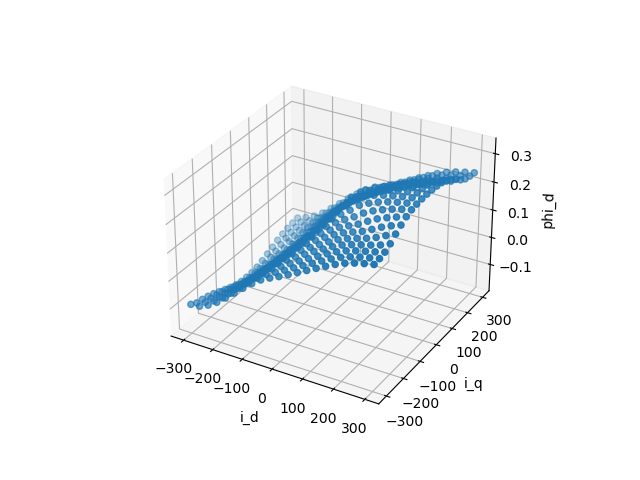

In [8]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(I_q_i2p_grid, I_d_i2p_grid, Phi_d_i2p[:,:,0])

ax.set_xlabel('i_d')
ax.set_ylabel('i_q')
ax.set_zlabel('phi_d');

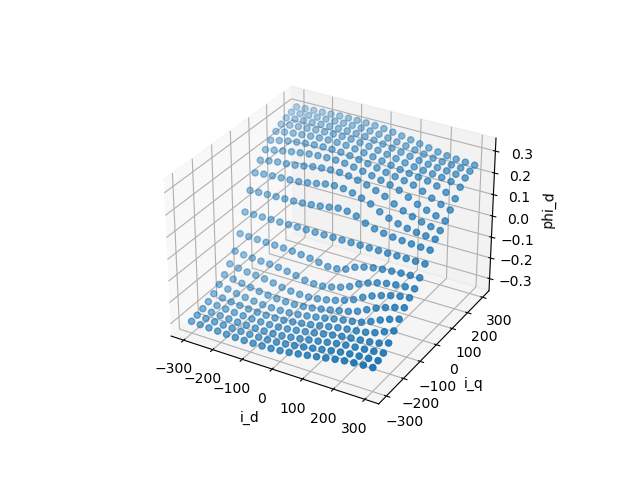

In [9]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(I_q_i2p_grid, I_d_i2p_grid, Phi_q_i2p[:,:,0])

ax.set_xlabel('i_d')
ax.set_ylabel('i_q')
ax.set_zlabel('phi_d');

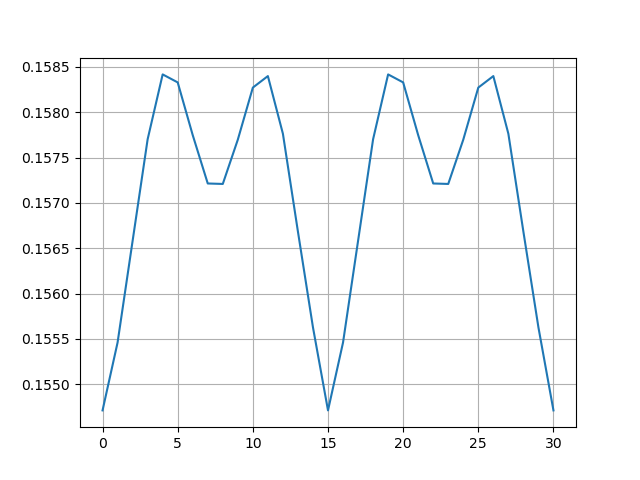

In [10]:
fig,axes = plt.subplots(nrows=1, sharex=True)

#i_d_idx,i_q_idx,theta_idx = v2i(0,0,0)
axes.plot(Theta_i2p,Phi_d_i2p[10,10,:])
#axes.plot(data['i_q'],data['phi_q'][i_d_idx,:,theta_idx])

#for ax in axes:
axes.grid()

## phi2i plots

In [11]:
data_p2i = np.load(f'pmsm_phi2i_{N}.npz')
I_d_p2i,I_q_p2i = data_p2i['i_d'],data_p2i['i_q']
Phi_d_p2i,Phi_q_p2i = data_p2i['phi_d'],data_p2i['phi_q']
Theta_p2i = data_p2i['theta']
Phi_d_p2i_grid, Phi_q_p2i_grid = np.meshgrid(Phi_d_p2i,Phi_q_p2i)

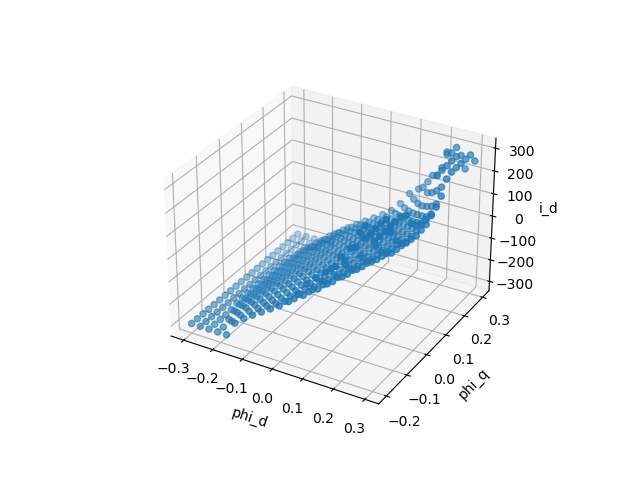

In [12]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(Phi_q_p2i_grid, Phi_d_p2i_grid, I_d_p2i[:,:,0])

ax.set_xlabel('phi_d')
ax.set_ylabel('phi_q')
ax.set_zlabel('i_d');

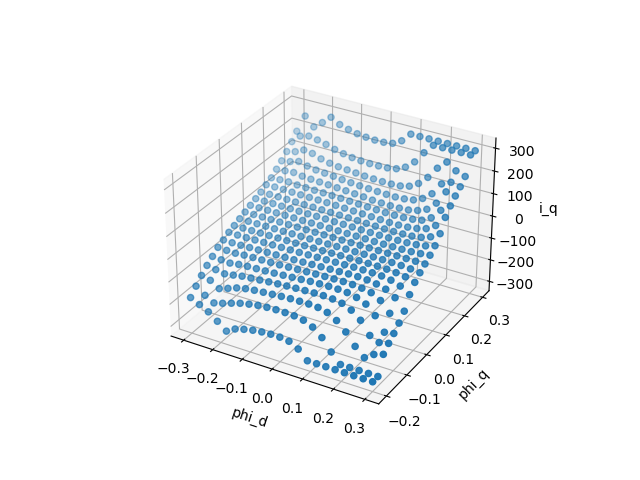

In [13]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(Phi_q_p2i_grid, Phi_d_p2i_grid, I_q_p2i[:,:,0])

ax.set_xlabel('phi_d')
ax.set_ylabel('phi_q')
ax.set_zlabel('i_q');

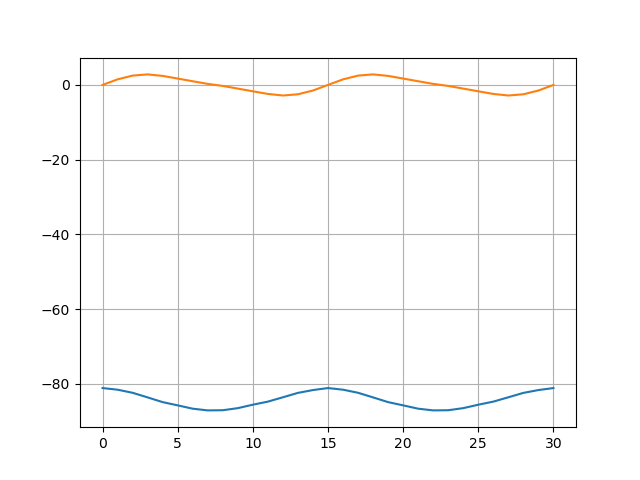

In [15]:
fig,axes = plt.subplots(nrows=1, sharex=True)

it = np.floor(N/2).astype(np.int32)
axes.plot(Theta_i2p,I_d_p2i[it,it,:])
axes.plot(Theta_i2p,I_q_p2i[it,it,:])

axes.grid()

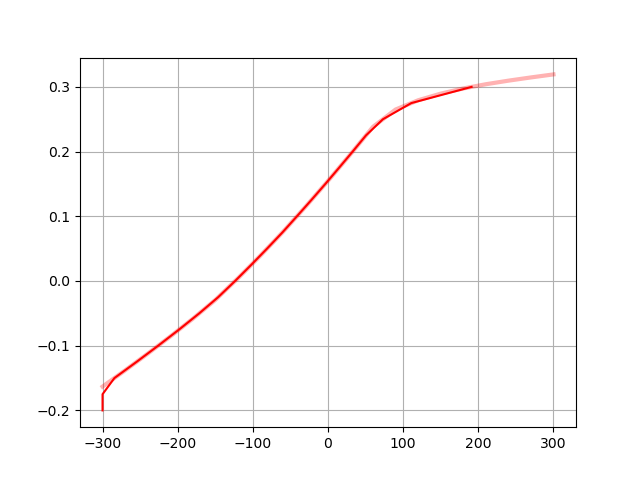

In [42]:
fig,axes = plt.subplots(nrows=1, sharex=True)

#for it in range(0,2):
it = 10
axes.plot(I_d_i2p, np.interp(I_d_i2p,I_d_i2p,Phi_d_i2p[:,it,0]) , 'r', alpha=0.3, lw=3)
    #axes.plot(I_d_i2p, np.interp(I_d_i2p,I_d_i2p,Phi_d_i2p[:,it,0]) , 'r', alpha=it/21, lw=3)
axes.plot(I_d_p2i[:,it,0],Phi_d_p2i, 'r')
#axes.plot(Theta_i2p,I_q_p2i[10,10,:])

#axes.plot(I_q_i2p,Phi_q_i2p[9,:,0], 'g', alpha=0.3, lw=3)
#axes.plot(I_q_p2i[9,:,0],Phi_q_p2i, 'g')

axes.grid()

In [29]:
#i_d, i_q -> LUT original phi_d,phi_q -> invLUT -> i_d, i_q

In [30]:
I_d_p2i[:,it,0]

array([-299.99995212, -299.99999673, -299.9999605 , -299.99994593,
       -293.13309236, -235.5033773 , -200.57881741, -172.88453622,
       -146.50783847, -120.5030337 ,  -94.07736134,  -64.04816553,
        -21.17353234,   35.21309934,   67.01930228,  110.32360207,
        147.86006551,  263.40911309,  293.27035009,  210.23502118,
        255.65537967])

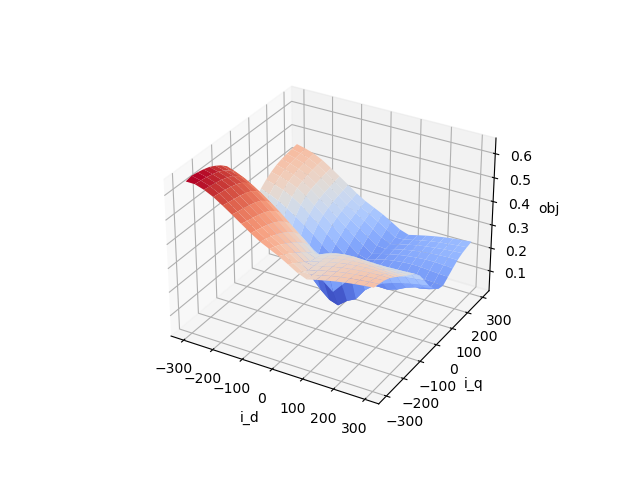

In [31]:
from matplotlib import cm

fig = plt.figure()
ax = plt.axes(projection='3d')

phi_d = 0.15
phi_q = 0.1
obj = (Phi_d_i2p[:,:,0]-phi_d)**2+(Phi_q_i2p[:,:,0]-phi_q)**2

#obj = np.abs(Phi_d_i2p[:,:,0]-phi_d)+np.abs(Phi_q_i2p[:,:,0]-phi_q)

ax.plot_surface(I_q_i2p_grid, I_d_i2p_grid,obj , cmap=cm.coolwarm)

ax.set_xlabel('i_d')
ax.set_ylabel('i_q')
ax.set_zlabel('obj');

In [32]:
np.unravel_index(np.argmin(obj),obj.shape)

(10, 11)

In [33]:
N = 11
offset = 5
I_d_p2i_grid,I_q_p2i_grid = np.meshgrid(range(N),range(N))

theta_t = 0.0

for irow in range(N):
    for icol in range(N):  
        phi_d = Phi_d_i2p[irow+offset,icol+offset,0]
        phi_q = Phi_q_i2p[irow+offset,icol+offset,0]
        i_d,i_q = i_eval_2(phi_d,phi_q,theta_t/(2*np.pi)*30,Phi_d_p2i,Phi_q_p2i,I_d_p2i,I_q_p2i,Theta_p2i)
        I_d_p2i_grid[irow,icol] = i_d
        I_q_p2i_grid[irow,icol] = i_q
        


In [185]:
i_eval_2(phi_d,phi_q,theta_t/(2*np.pi)*30,Phi_d_p2i,Phi_q_p2i,I_d_p2i,I_q_p2i,Theta_p2i)

(116.51618328305631, 141.70293762719382)

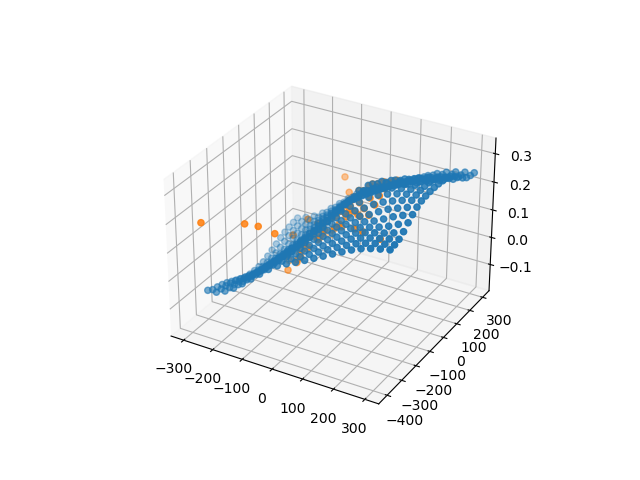

In [186]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(I_q_i2p_grid, I_d_i2p_grid, Phi_d_i2p[:,:,0])
ax.scatter(I_d_p2i_grid, I_q_p2i_grid, Phi_d_i2p[offset:(offset+N),offset:(offset+N),0])



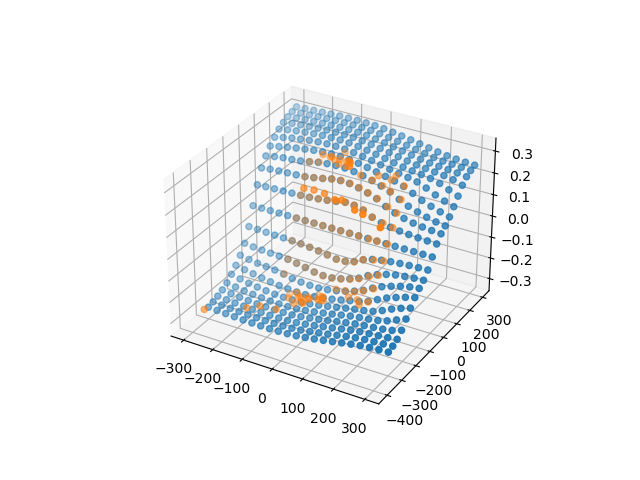

In [187]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(I_q_i2p_grid, I_d_i2p_grid, Phi_q_i2p[:,:,0])
ax.scatter(I_d_p2i_grid, I_q_p2i_grid, Phi_q_i2p[offset:(offset+N),offset:(offset+N),0])


In [122]:
Phi_d_i2p[offset:(offset+N),offset:(offset+N),0]

array([[-0.08033657, -0.08324693, -0.08733635, -0.09316227, -0.10117353,
        -0.10711332, -0.11036897, -0.1120223 , -0.11236677, -0.11138373],
       [-0.05967156, -0.06234104, -0.06580555, -0.07029233, -0.07650547,
        -0.08184127, -0.0842959 , -0.08568969, -0.08587265, -0.08493785],
       [-0.03170237, -0.03387426, -0.03671846, -0.04092545, -0.0465448 ,
        -0.05314934, -0.05699851, -0.05837139, -0.05844446, -0.05756604],
       [-0.00298741, -0.00427036, -0.00588036, -0.008393  , -0.01207499,
        -0.01890746, -0.02621216, -0.02907142, -0.02928291, -0.02829859],
       [ 0.02561049,  0.02520462,  0.02477192,  0.02416259,  0.02254906,
         0.0182293 ,  0.00999014,  0.00471896,  0.00404108,  0.00557271],
       [ 0.05335718,  0.05418213,  0.0551864 ,  0.05655114,  0.05679878,
         0.05459608,  0.04751441,  0.04097458,  0.03914774,  0.04191392],
       [ 0.07760392,  0.08028624,  0.08405302,  0.08785773,  0.09026262,
         0.09017694,  0.08659788,  0.07847676

In [121]:
I_d_p2i_grid.shape

(10, 10)

In [44]:
import scipy.io as sio
sio.savemat('pmsm_phi2i_21p.mat', {'data': data_p2i})

In [53]:
simulink = sio.loadmat('./simulink/pmsm_simulink_10ohm.mat')

In [54]:
simulink['simout']

array([[ 0.00000000e+00,  4.12023776e+00,  4.67439297e+02, ...,
        -4.12023776e-03, -5.42131228e-01,  4.38372964e-01],
       [ 1.45650326e-07,  3.90468755e+00,  4.67546735e+02, ...,
        -4.14282956e-03, -5.42129072e-01,  4.36726061e-01],
       [ 4.36950979e-07,  3.51439174e+00,  4.67736693e+02, ...,
        -4.22880767e-03, -5.42119744e-01,  4.33427496e-01],
       ...,
       [ 9.98771660e-03,  4.24767392e+02, -9.96156716e+01, ...,
         9.03759638e-03, -4.44185962e-01,  7.87931729e-01],
       [ 9.99408242e-03,  4.26443968e+02, -8.66160321e+01, ...,
         1.53015563e-02, -4.50546844e-01,  1.61134550e+00],
       [ 1.00000000e-02,  4.27721655e+02, -7.42830832e+01, ...,
         2.11092164e-02, -4.56591940e-01,  2.37710708e+00]])

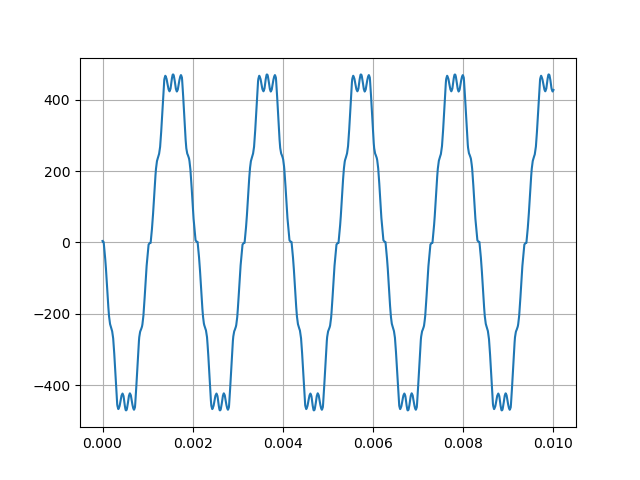

In [55]:
fig,axes = plt.subplots(nrows=1, sharex=True)

#for it in range(0,2):
it = 10
axes.plot(simulink['simout'][:,0],simulink['simout'][:,1])


axes.grid()

In [51]:
simulink['simout'].shape

(1106, 12)